# Relative Strength Index
## by Kashish Gupta (Masters in Quantitative Economics, UCLA)

### This notebook contains estimation of RSI for META stock
#### Data source: Yahoo Finance 

In [1]:
import pandas as pd
import statsmodels.api as sm
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
from scipy import stats
from math import sqrt

In [2]:
import yfinance as yf
import getFamaFrenchFactors as gff

In [3]:
# pick the asset of interest, here I have chosen stock of Meta for a period of 10 years 

ticker = 'meta'                      # choose the stock of interest
start = dt.datetime(2013,1,31)       # start date 
end = dt.datetime.now()              # takes date today automatically, 04th Jan 2023

In [4]:
# download the relevant dataset from yahoo finance 

stock_data = yf.download(ticker, start, end)

[*********************100%***********************]  1 of 1 completed


In [5]:
stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-01-31,29.150000,31.469999,28.740000,30.980000,30.980000,190744900
2013-02-01,31.010000,31.020000,29.629999,29.730000,29.730000,85856700
2013-02-04,29.059999,29.200001,28.010000,28.110001,28.110001,92362200
2013-02-05,28.260000,28.959999,28.040001,28.639999,28.639999,47948200
2013-02-06,28.740000,29.290001,28.660000,29.049999,29.049999,38375900
...,...,...,...,...,...,...
2023-01-03,122.820000,126.370003,122.279999,124.739998,124.739998,35528500
2023-01-04,127.379997,129.050003,125.849998,127.370003,127.370003,32397100
2023-01-05,126.129997,128.520004,124.540001,126.940002,126.940002,25447100


# RSI calculation

In [6]:
def get_rsi(Close, lookback):     # this function take closing price of the stock and lookback period 
    ret = Close.diff()            # this function calculates returns by taking first difference 
    up = []
    down = []
    for i in range(len(ret)):    
        if ret[i] < 0:            # if we have a loss 
            up.append(0)
            down.append(ret[i])
        else:                     # if we have a gain 
            up.append(ret[i])
            down.append(0)
    up_series = pd.Series(up)
    down_series = pd.Series(down).abs()
    up_ewm = up_series.ewm(com = lookback - 1, adjust = False).mean()        # calculating exponential moving averageb
    down_ewm = down_series.ewm(com = lookback - 1, adjust = False).mean()
    rs = up_ewm/down_ewm
    rsi = 100 - (100 / (1 + rs))
    rsi_df = pd.DataFrame(rsi).rename(columns = {0:'rsi'}).set_index(Close.index)
    rsi_df = rsi_df.dropna()
    return rsi_df[3:]

stock_data['rsi_14'] = get_rsi(stock_data['Close'], 14)
stock_data = stock_data.dropna()
stock_data

,Open,High,Low,Close,Adj Close,Volume,rsi_14
Date,,,,,,,
2013-02-06,28.740000,29.290001,28.660000,29.049999,29.049999,38375900,27.339302
2013-02-07,29.110001,29.150000,28.270000,28.650000,28.650000,34540100,24.182430
2013-02-08,28.889999,29.170000,28.510000,28.549999,28.549999,37708800,23.453308
2013-02-11,28.610001,28.680000,28.040001,28.260000,28.260000,37361800,21.434932
2013-02-12,27.670000,28.160000,27.100000,27.370001,27.370001,93498700,16.688280
...,...,...,...,...,...,...,...
2023-01-03,122.820000,126.370003,122.279999,124.739998,124.739998,35528500,60.008232
2023-01-04,127.379997,129.050003,125.849998,127.370003,127.370003,32397100,62.736570
2023-01-05,126.129997,128.520004,124.540001,126.940002,126.940002,25447100,61.991907


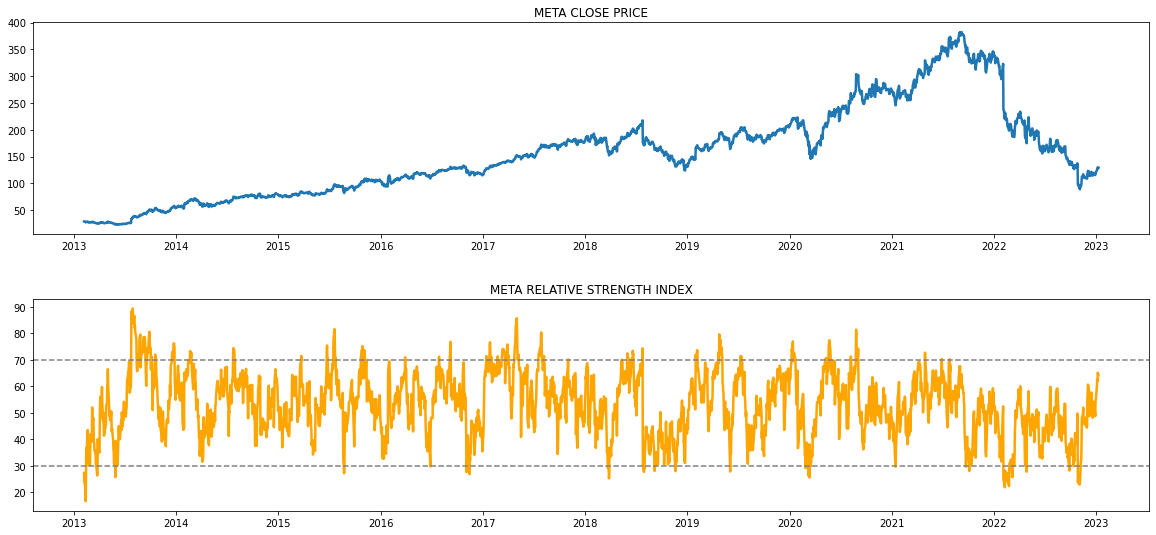

In [7]:
# plotting the RSI plot 

plt.figure(figsize=(20,10))
ax1 = plt.subplot2grid((10,1), (0,0), rowspan = 4, colspan = 1)
ax2 = plt.subplot2grid((10,1), (5,0), rowspan = 4, colspan = 1)
ax1.plot(stock_data['Close'], linewidth = 2.5)
ax1.set_title('META CLOSE PRICE')
ax2.plot(stock_data['rsi_14'], color = 'orange', linewidth = 2.5)
ax2.axhline(30, linestyle = '--', linewidth = 1.5, color = 'grey')
ax2.axhline(70, linestyle = '--', linewidth = 1.5, color = 'grey')
ax2.set_title('META RELATIVE STRENGTH INDEX')
plt.show()

# the direction of the market is revealed by RSI before the turn actually happens, hence RSI is a leading indicator

# trading strategy

In [8]:
def trading_strategy(prices, rsi):       # prices and RSI are parameters for this function 
    buy_price = []
    sell_price = []
    rsi_signal = []
    signal = 0

    for i in range(len(rsi)):           
        if rsi[i-1] > 30 and rsi[i] < 30:      
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                rsi_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                rsi_signal.append(0)
        elif rsi[i-1] < 70 and rsi[i] > 70:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                rsi_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                rsi_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            rsi_signal.append(0)
            
    return buy_price, sell_price, rsi_signal
            

buy_price, sell_price, rsi_signal = trading_strategy(stock_data['Close'], stock_data['rsi_14'])

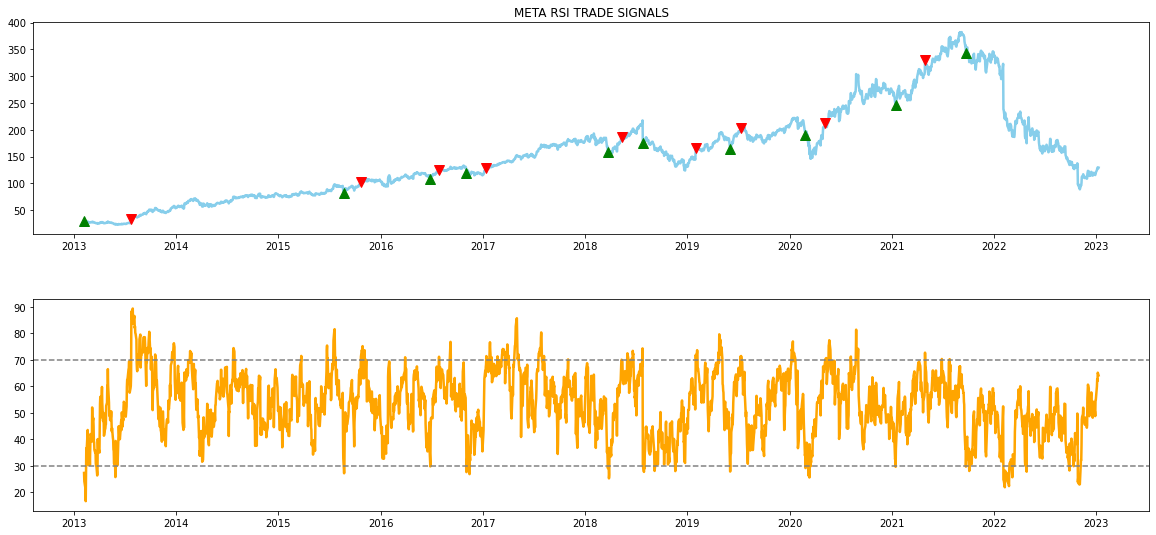

In [9]:
plt.figure(figsize=(20,10))
ax1 = plt.subplot2grid((10,1), (0,0), rowspan = 4, colspan = 1)
ax2 = plt.subplot2grid((10,1), (5,0), rowspan = 4, colspan = 1)
ax1.plot(stock_data['Close'], linewidth = 2.5, color = 'skyblue', label = 'IBM')
ax1.plot(stock_data.index, buy_price, marker = '^', markersize = 10, color = 'green', label = 'BUY SIGNAL')
ax1.plot(stock_data.index, sell_price, marker = 'v', markersize = 10, color = 'r', label = 'SELL SIGNAL')
ax1.set_title('META RSI TRADE SIGNALS')
ax2.plot(stock_data['rsi_14'], color = 'orange', linewidth = 2.5)
ax2.axhline(30, linestyle = '--', linewidth = 1.5, color = 'grey')
ax2.axhline(70, linestyle = '--', linewidth = 1.5, color = 'grey')
plt.show()

# green represents buy signal when RSI line crosses from above to below the lower band or the oversold level

# creating a position

In [10]:
position1 = []     # create an empty list 
for i in range(len(rsi_signal)):   # gives all the values in rsi_signal (here they are -1,0 and 1)
    if rsi_signal[i] > 1:           
        position1.append(0)
    else:
        position1.append(1)
        
for i in range(len(stock_data['Close'])):
    if rsi_signal[i] == 1:
        position1[i] = 1
    elif rsi_signal[i] == -1:
        position1[i] = 0
    else:
        position1[i] = position1[i-1]
        
rsi = stock_data['rsi_14']
close_price = stock_data['Close']
rsi_signal = pd.DataFrame(rsi_signal).rename(columns = {0:'rsi_signal'}).set_index(stock_data.index)
position1 = pd.DataFrame(position1).rename(columns = {0:'rsi_position'}).set_index(stock_data.index)

frames1 = [close_price, rsi, rsi_signal, position1]
strategy1 = pd.concat(frames1, join = 'inner', axis = 1)

strategy1.head()

,Close,rsi_14,rsi_signal,rsi_position
Date,,,,
2013-02-06,29.049999,27.339302,1,1
2013-02-07,28.650000,24.182430,0,1
2013-02-08,28.549999,23.453308,0,1
2013-02-11,28.260000,21.434932,0,1
2013-02-12,27.370001,16.688280,0,1


# backtesting

In [17]:
pip install termcolor

Note: you may need to restart the kernel to use updated packages.


In [32]:
# process of seeing how well our trading strategy has performed on the given stock data

from math import floor
from termcolor import colored as cl 


meta_ret = pd.DataFrame(np.diff(stock_data['Close'])).rename(columns = {0:'returns'})
rsi_strategy_ret = []

for i in range(len(meta_ret)):
    returns = meta_ret['returns'][i]*strategy1['rsi_position'][i]
    rsi_strategy_ret.append(returns)
    
rsi_strategy_ret_df = pd.DataFrame(rsi_strategy_ret).rename(columns = {0:'rsi_returns'})
investment_value = 100000
number_of_stocks = floor(investment_value/stock_data['Close'][-1])
rsi_investment_ret = []

for i in range(len(rsi_strategy_ret_df['rsi_returns'])):
    returns = number_of_stocks*rsi_strategy_ret_df['rsi_returns'][i]
    rsi_investment_ret.append(returns)

rsi_investment_ret_df = pd.DataFrame(rsi_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(rsi_investment_ret_df['investment_returns']), 2)
profit_percentage = ((total_investment_ret/investment_value)*100)
print(cl('Profit gained from the RSI strategy by investing $100k in META : {}'.format(total_investment_ret), attrs = ['bold']))
print(cl('Profit percentage of the RSI strategy : {}%'.format(profit_percentage), attrs = ['bold']))

Profit gained from the RSI strategy by investing $100k in META : 378.31
Profit percentage of the RSI strategy : 0.37831000000000004%
